## Part 2B: Continuous shape analysis

In this notebook, we will learn the basics of shape analysis on parametric spline curves.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from spline_models.spline_curve_model import B3_spline_curve
from spline_models.spline_shape_space import B3_shape_space
from spline_models.spline_shape_space import B3_PCA

In [2]:
plt.rcParams['figure.dpi'] = 200

### 0. Data loading

**0.1** Run the lines below to load spline-based object models of objects in the C. elegans dataset.

*The C. elegans dataset is presented and prepared in notebook 1 - Data preparation.*

In [3]:
dataset='data/C. elegans/spline_models.npy'
spline_models=np.load(dataset, allow_pickle=True)

In [4]:
# The number of parameters in our spline models is important for the shape space construction
M=spline_models[0].M
print("M="+str(M))

# The nature of the spline curve (open or closed) is important for the shape space construction
closed_curve=spline_models[0].closed
print("Closed curve? "+str(closed_curve))

M=6
Closed curve? False


**0.2** Run the lines below to visualize a set of a few randomly selected models from the collection.

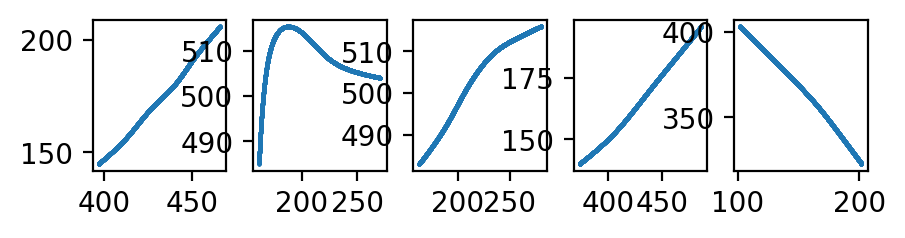

In [5]:
number=5
inds=np.random.choice(len(spline_models)-1, size=number, replace=False)

fig, ax = plt.subplots(1,number, figsize=(number,1))
for i in range(number):
    spline_model=spline_models[i]
    spline_model_points=spline_model.sample(1000)
    ax[i].scatter(spline_model_points[:,0],spline_model_points[:,1],s=.2)

**0.3** Spline models are continuously-defined objects. In order to draw them with the usual ``scatter`` function from matplotlib, we can draw as many sample points along the model as we like. The function below will be used to draw open cubic B-spline curves of ``M`` points from a vector of 2D coefficients, represented in complex number notation.

In [6]:
def draw_spline_model(complex_spline_parameters):
    spline_model=B3_spline_curve(M, closed_curve)
    
    spline_parameters=np.zeros((len(complex_spline_parameters),2))
    spline_parameters[:,0]=complex_spline_parameters.real
    spline_parameters[:,1]=complex_spline_parameters.imag
    spline_model.coefs=spline_parameters
    
    spline_model_points=spline_model.sample(1000)
    return spline_model_points

### 1. Continuous Kendall shape space

**1.1** To build a continuous shape space of spline curves, we will again rely on the complex representation introduced in 2A - 1.3. Run the lines below to convert each vectors of spline parameters into complex numbers.

In [7]:
# Retrieves vectors of spline parameters
spline_parameters=[]
for spline_model in spline_models:
    spline_parameters.append(spline_model.coefs)
spline_parameters=np.array(spline_parameters)

In [8]:
# Converts them all to complex numbers
complex_spline_parameters=spline_parameters[:,:,0] + 1j*spline_parameters[:,:,1]

**1.2** The module ``spline_shape_space`` constructs the shape space of open cubic B-splines of ``M`` parameters following [1]. As in the case of point-based models, the first thing to do is center and normalize the objects, turning them into preshapes.

[1] Song, A., Uhlmann, V., Fageot, J., & Unser, M. (2020). Dictionary learning for two-dimensional Kendall shapes. SIAM Journal on Imaging Sciences, 13(1), 141-175.

In [9]:
# Creates the shape space structure for open cubic B-spline curves of M parameters
shape_space=B3_shape_space(M, closed_curve)

In [10]:
# Centers and normalizes (=preshapes) the object models
complex_spline_preshapes=shape_space.preshapeDataset(complex_spline_parameters)

**1.3** The optimal alignment problem can be solved in a similar manner as in the point-based model case. To convince yourself of it, compare the function ``theta`` of ``B3_shape_space`` with the code from 2A - 1.4.

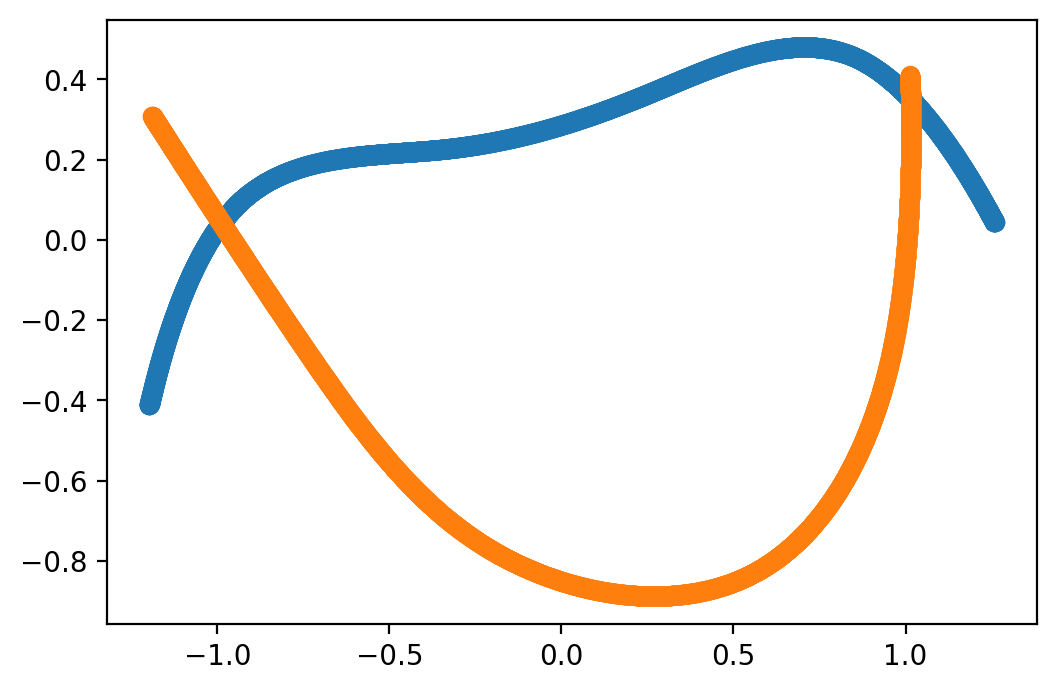

In [11]:
# Picks two random models - reload if you are not happy with the selection :)
random=np.random.choice(len(complex_spline_preshapes)-1, size=2, replace=False)

sample_preshape_1=complex_spline_preshapes[random[0]]
sample_preshape_2=complex_spline_preshapes[random[1]]

sample_preshape_1_points=draw_spline_model(sample_preshape_1)
plt.scatter(sample_preshape_1_points[:,0],sample_preshape_1_points[:,1])

sample_preshape_2_points=draw_spline_model(sample_preshape_2)
plt.scatter(sample_preshape_2_points[:,0],sample_preshape_2_points[:,1])
plt.show()

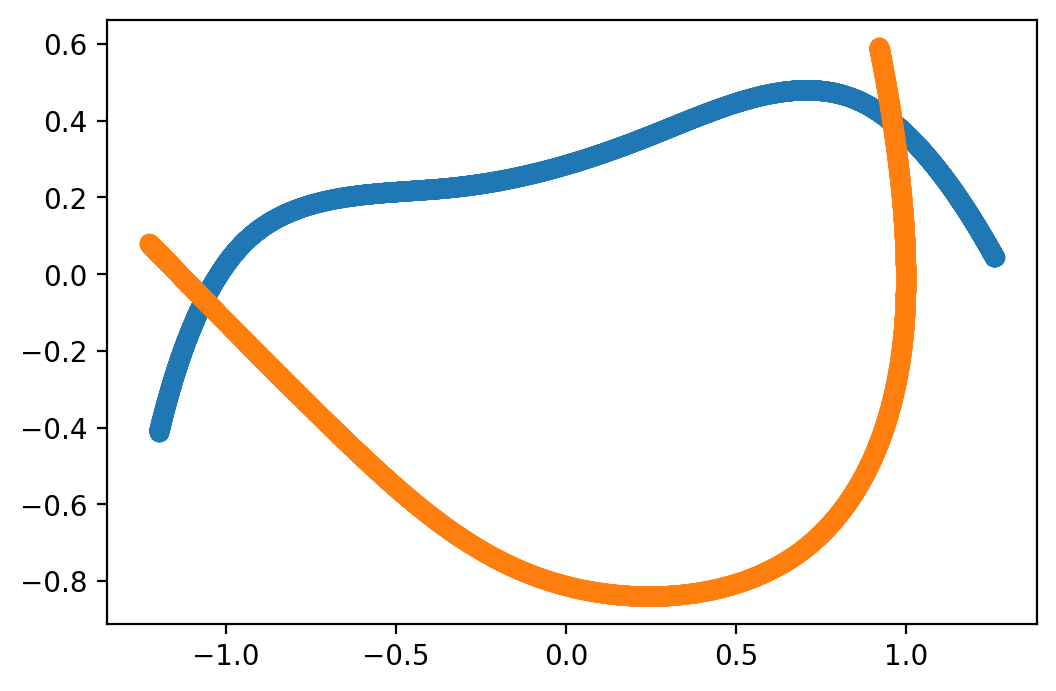

In [12]:
# Aligns the second shape onto the first one and displays the result
aligned=shape_space.align(sample_preshape_2,sample_preshape_1)

plt.scatter(sample_preshape_1_points[:,0],sample_preshape_1_points[:,1])

aligned_points=draw_spline_model(aligned)
plt.scatter(aligned_points[:,0],aligned_points[:,1])
plt.show()

**1.4** The function below computes the Fréchet mean of the spline-based model collection. 

You will notice that it looks very similar to what you obtained in 2A - 2.2 (which is reassuring!). It also highlights the strength of spline-based models: we are working with continuous curves (i.e., infinitely more points than in 2A), but we only need ``M=6`` complex numbers to do so (i.e., twice less than in 2A, where ``N=12``).

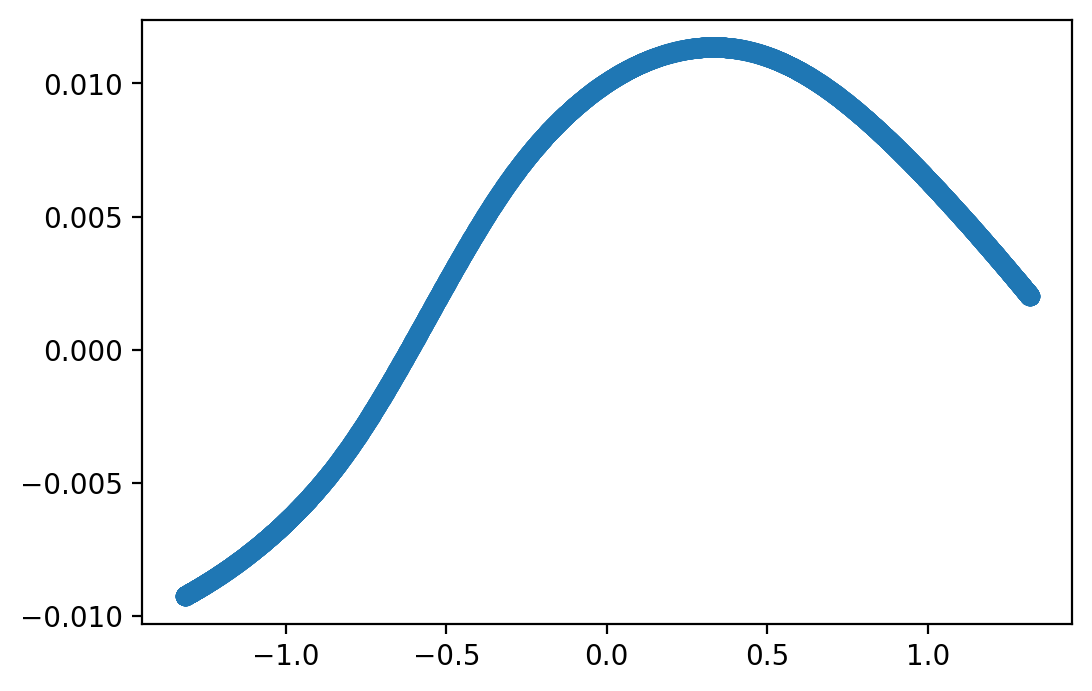

In [13]:
mean_shape_Frechet=shape_space.meanFrechet(complex_spline_preshapes)

mean_shape_Frechet_points=draw_spline_model(mean_shape_Frechet)
plt.scatter(mean_shape_Frechet_points[:,0],mean_shape_Frechet_points[:,1])
plt.show()

**1.5** The various distances we saw in 2A can also be defined in the spline shape space. The lines below compute the geodesic path between a randomly picked shape in the dataset and the Fréchet mean, and visualize elements along the path.

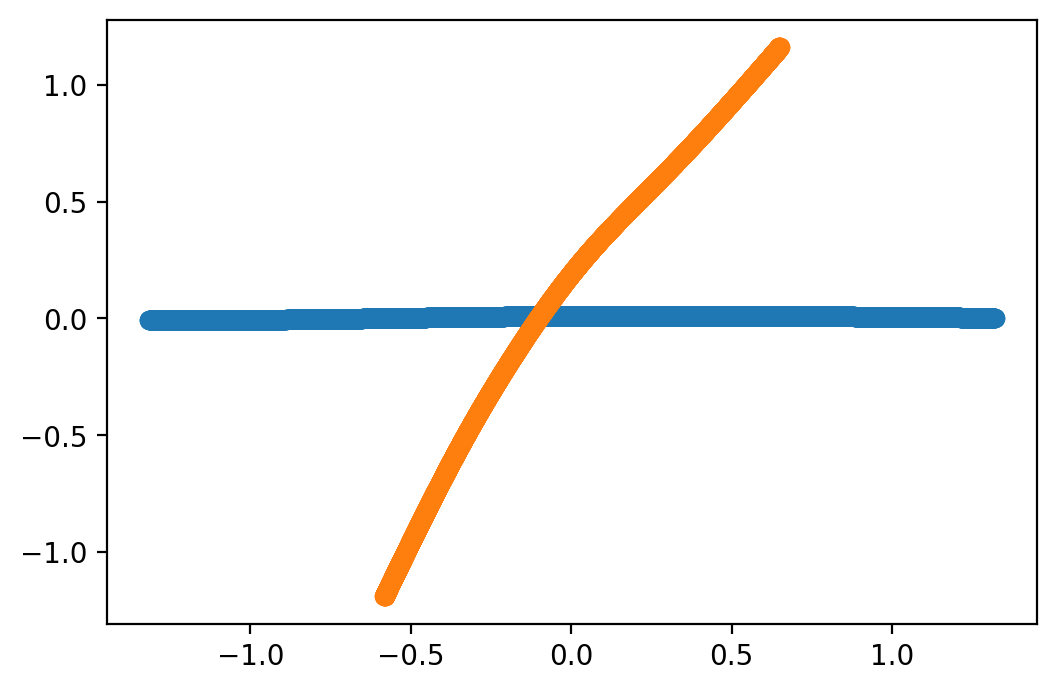

In [14]:
# Picks one random complex preshape and visualize it with the Fréchet mean - reload if you are not happy with the selection :)
random=np.random.choice(len(complex_spline_preshapes)-1, size=1, replace=False)[0]
sample_preshape=complex_spline_preshapes[random]

plt.scatter(mean_shape_Frechet_points[:,0],mean_shape_Frechet_points[:,1])

sample_preshape_points=draw_spline_model(sample_preshape)
plt.scatter(sample_preshape_points[:,0],sample_preshape_points[:,1])
plt.show()

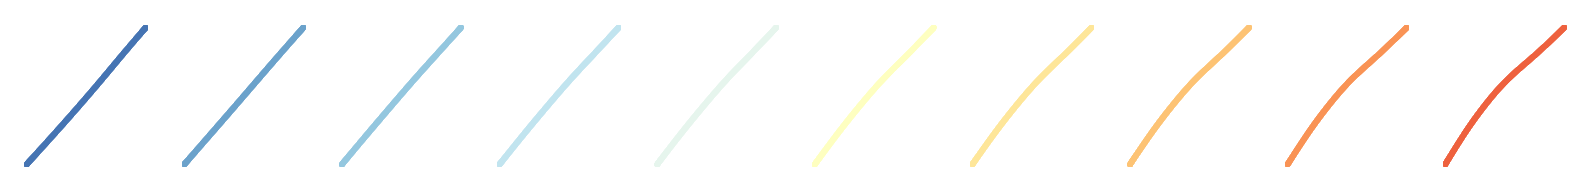

In [15]:
# Computes N steps along the geodesic path
steps=10
path=shape_space.geodesicPath(mean_shape_Frechet,sample_preshape,steps)

fig, ax = plt.subplots(1,steps, figsize=(steps,1))
colors = cm.RdYlBu(np.linspace(0.9, 0.1, len(path)))
for i in range(steps):
    path_points=draw_spline_model(path[i])
    ax[i].scatter(path_points[:,0],path_points[:,1], s=.5, color=colors[i])
    ax[i].axis('off')

### 2. Continuous shape space PCA on the whole dataset

**2.1** The lines below perform PCA in the tangent plane around the Fréchet mean using the logarithmic and exponential maps appropriately and displays the explained variance. Do you see any difference with respect to 2A - 3.1?

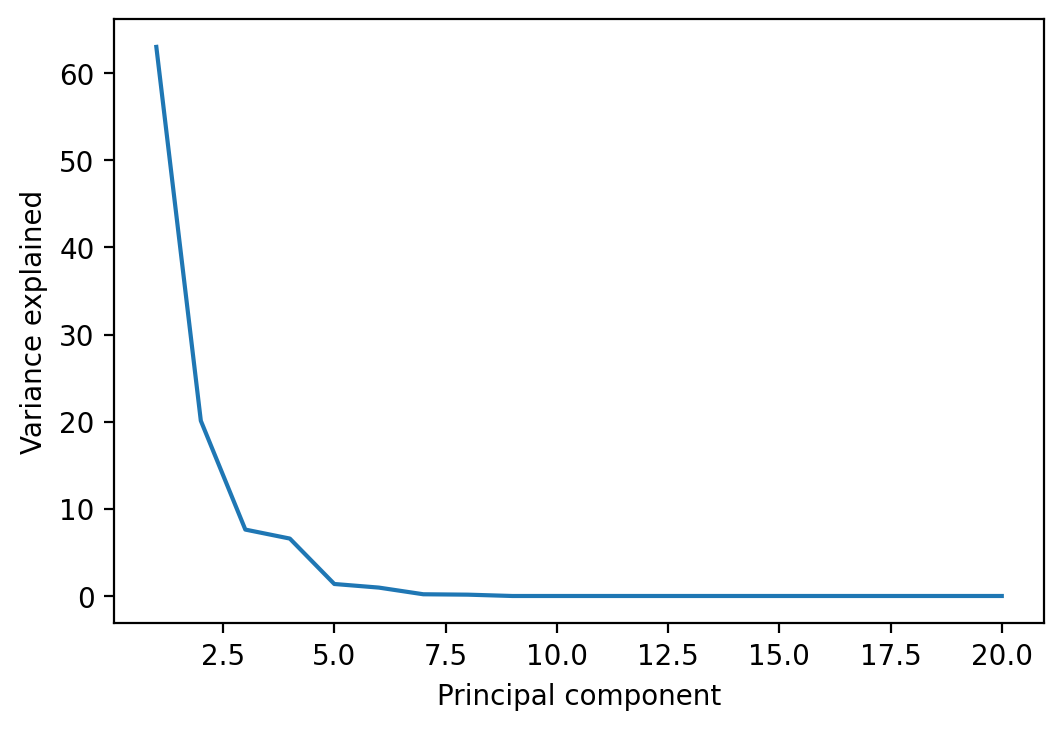

In [16]:
tangent_vectors=np.zeros(complex_spline_preshapes.shape, dtype=complex)
for i in range(len(complex_spline_preshapes)):
    tangent_vectors[i]=shape_space.log(mean_shape_Frechet, complex_spline_preshapes[i])

tangent_plane_pca = B3_PCA(M, closed_curve, mean_shape_Frechet)
tangent_plane_pca.fit(tangent_vectors)
    
plt.plot(np.linspace(1,len(tangent_plane_pca.diag),len(tangent_plane_pca.diag)),100*tangent_plane_pca.diag/np.sum(tangent_plane_pca.diag))
plt.xlabel("Principal component")
plt.ylabel("Variance explained")
plt.show()

**2.2** The lines below retreive the four first modes of shape variation and visualize them around the mean. Do you see any difference with respect to 2A - 3.2?

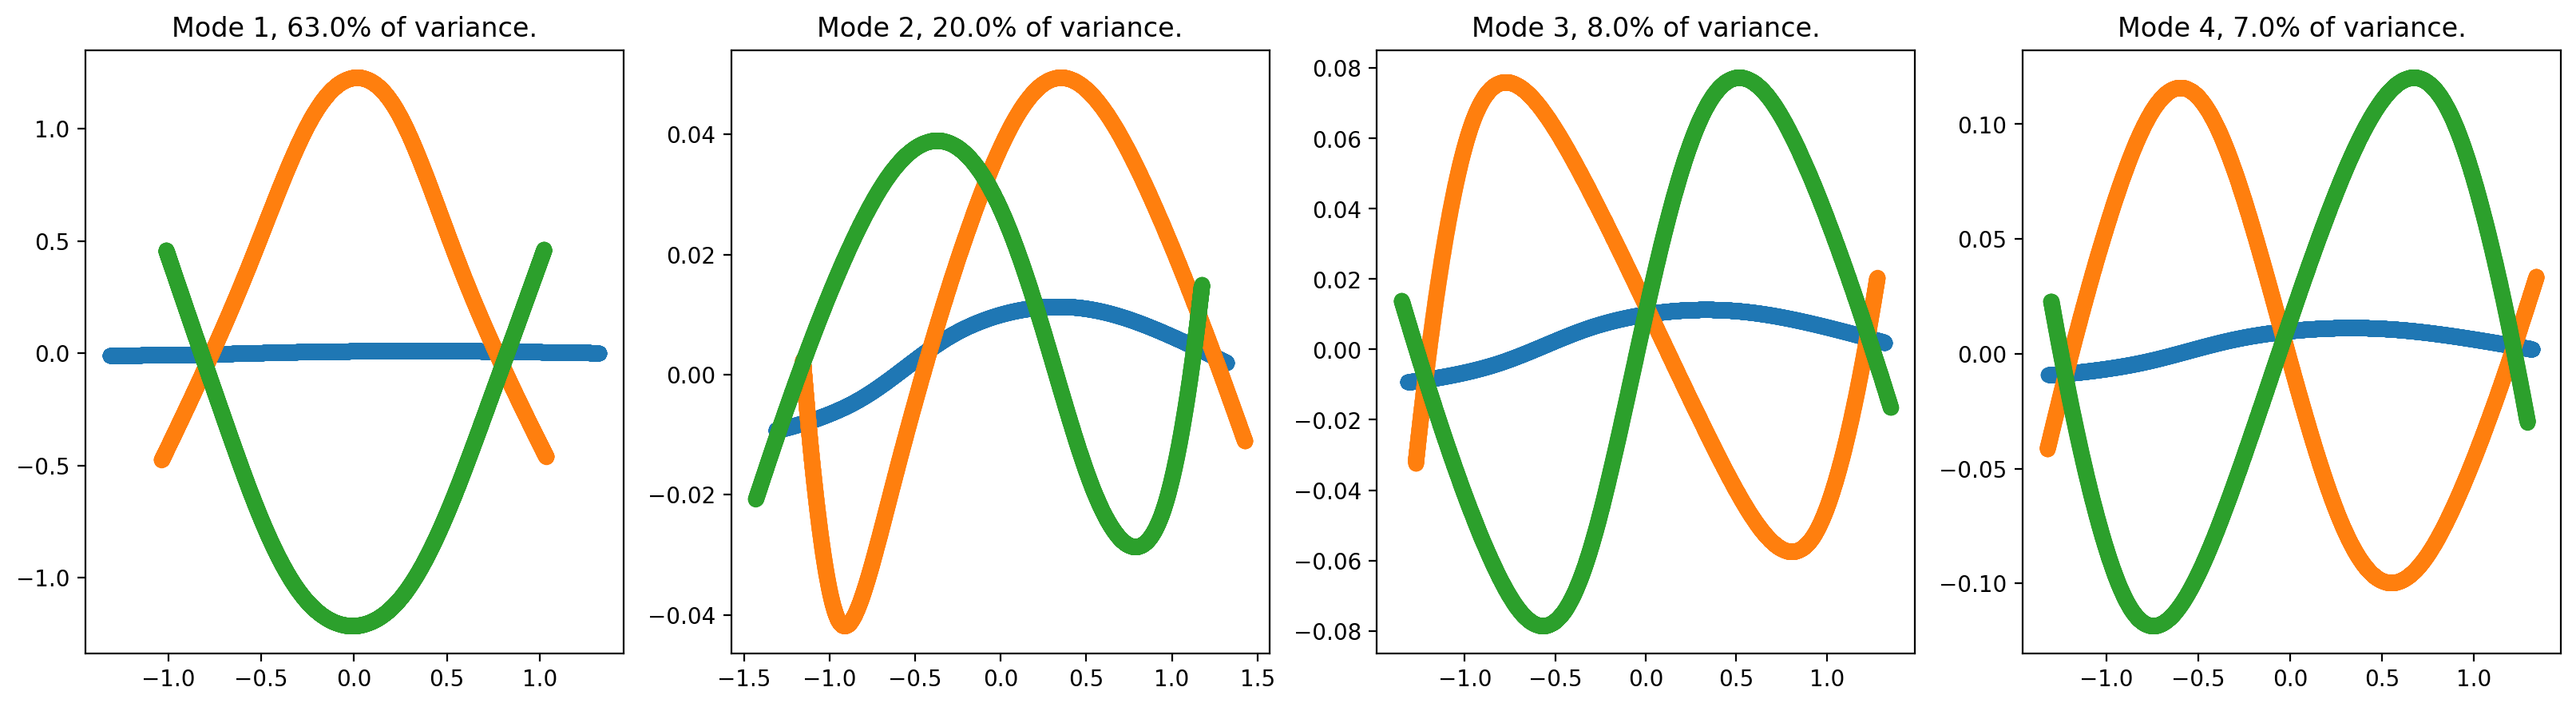

In [17]:
K=4

pcWeights=np.zeros((K,2*tangent_plane_pca.M))
for i in range(K):
    pcWeights[i]=tangent_plane_pca.project(tangent_vectors[i])

modes_shape=np.zeros((K,2,tangent_plane_pca.M),dtype=np.complex)
for i in range(K):
    mode=np.std(pcWeights[:,i])*np.sqrt(tangent_plane_pca.diag[i])*tangent_plane_pca.complexPC[:,i]
    modes_shape[i][0]=shape_space.exponentialMap(mean_shape_Frechet, mode)
    modes_shape[i][1]=shape_space.exponentialMap(mean_shape_Frechet, -mode)
    
fig, ax = plt.subplots(1, K, figsize=(5*K,5))
for i in range(K):
    ax[i].scatter(mean_shape_Frechet_points[:,0],mean_shape_Frechet_points[:,1])
    
    modes_shape_0_points=draw_spline_model(modes_shape[i][0])
    ax[i].scatter(modes_shape_0_points[:,0],modes_shape_0_points[:,1])
    
    modes_shape_1_points=draw_spline_model(modes_shape[i][1])
    ax[i].scatter(modes_shape_1_points[:,0],modes_shape_1_points[:,1])
    
    percent_variance=np.round(100*tangent_plane_pca.diag[i]/np.sum(tangent_plane_pca.diag))
    ax[i].set_title("Mode "+str(i+1)+", "+str(percent_variance)+"% of variance.")

### 3. Continuous shape space PCA on classes

We actually know that the shape distribution is bimodal, because there are dead and alive worms. To have a clearer picture of shape variability, we can thus carry out shape PCA on each class individually.

**3.1** Run the lines below to split the dataset into a collection of alive and a collection of dead C. elegans samples.  

In [18]:
label_data='data/C. elegans/labels.npy'
labels=np.load(label_data)

In [19]:
complex_spline_preshapes_dead=complex_spline_preshapes[np.where(labels==0)]
complex_spline_preshapes_live=complex_spline_preshapes[np.where(labels==1)]

**3.2** Run the lines below to visualize a set of a few randomly selected models from each collection.

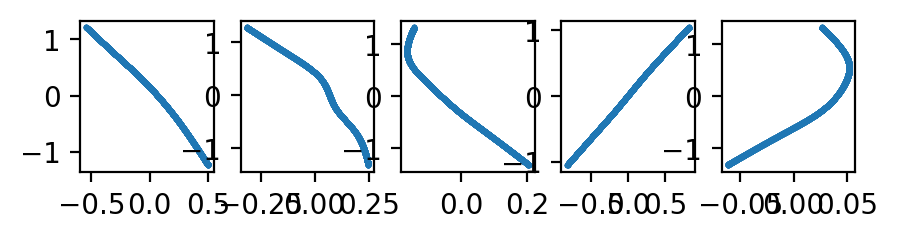

In [20]:
# Dead C. elegans
number=5
inds=np.random.choice(len(complex_spline_preshapes_dead)-1, size=number, replace=False)

fig, ax = plt.subplots(1,number, figsize=(number,1))
for i in range(number):
    sample_points=draw_spline_model(complex_spline_preshapes_dead[inds[i]])
    ax[i].scatter(sample_points[:,0],sample_points[:,1],s=1)

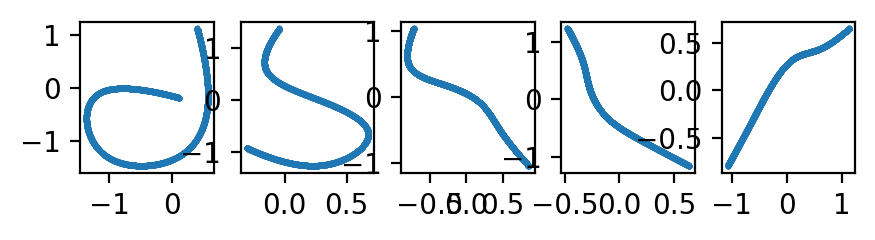

In [21]:
# Live C. elegans
number=5
inds=np.random.choice(len(complex_spline_preshapes_live)-1, size=number, replace=False)

fig, ax = plt.subplots(1,number, figsize=(number,1))
for i in range(number):
    sample_points=draw_spline_model(complex_spline_preshapes_live[inds[i]])
    ax[i].scatter(sample_points[:,0],sample_points[:,1],s=1)

**3.3** Compute and visualize the Fréchet mean for each individual class, adapting the code from 1.3. How do they differ from what you got in 1.3?

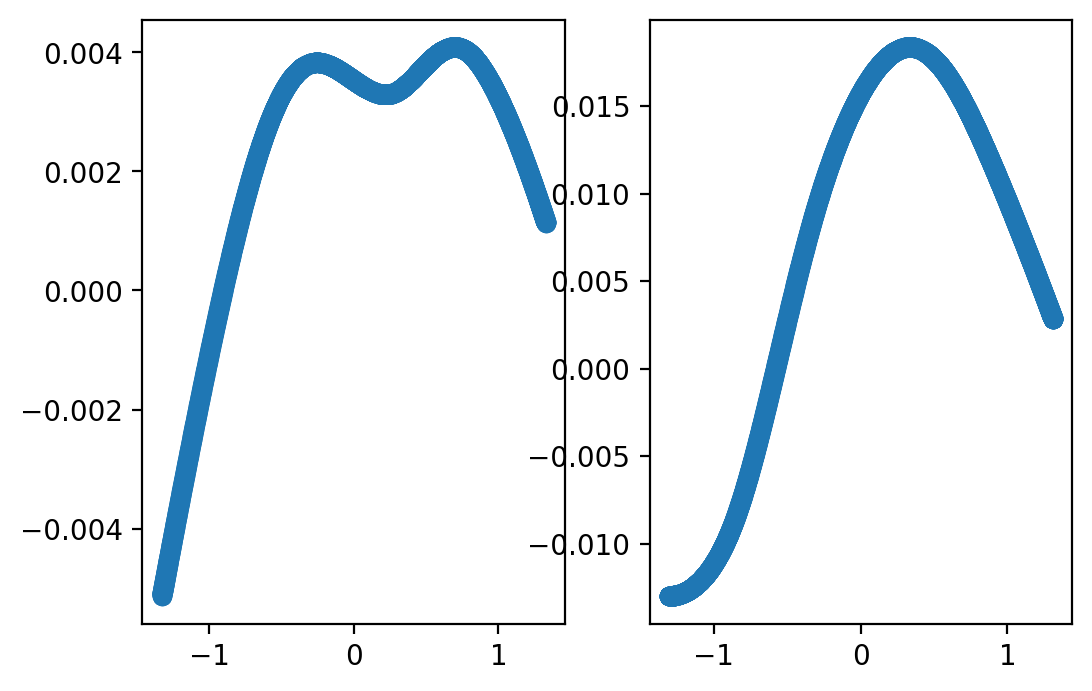

In [22]:
# Solution:
mean_shape_Frechet_dead=shape_space.meanFrechet(complex_spline_preshapes_dead)
mean_shape_Frechet_live=shape_space.meanFrechet(complex_spline_preshapes_live)

fig, ax = plt.subplots(1,2)
mean_shape_Frechet_dead_points=draw_spline_model(mean_shape_Frechet_dead)
ax[0].scatter(mean_shape_Frechet_dead_points[:,0],mean_shape_Frechet_dead_points[:,1])
mean_shape_Frechet_live_points=draw_spline_model(mean_shape_Frechet_live)
ax[1].scatter(mean_shape_Frechet_live_points[:,0],mean_shape_Frechet_live_points[:,1])
plt.show()

**3.4** For each class, perform continuous shape PCA by adapting the code from 2.1.

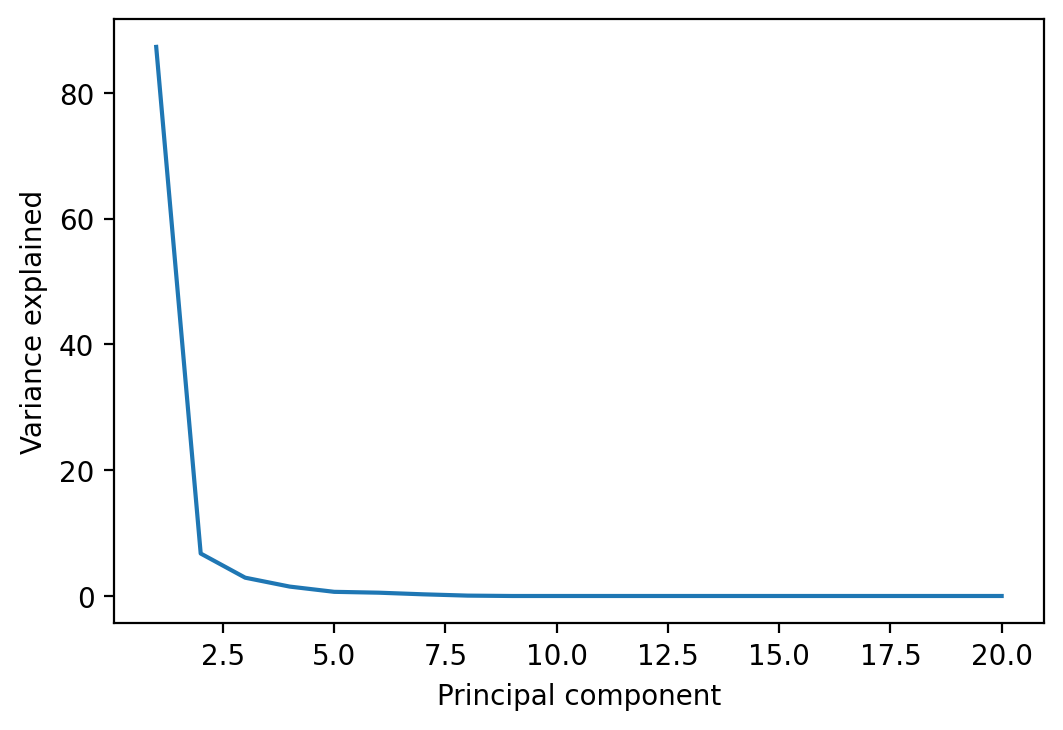

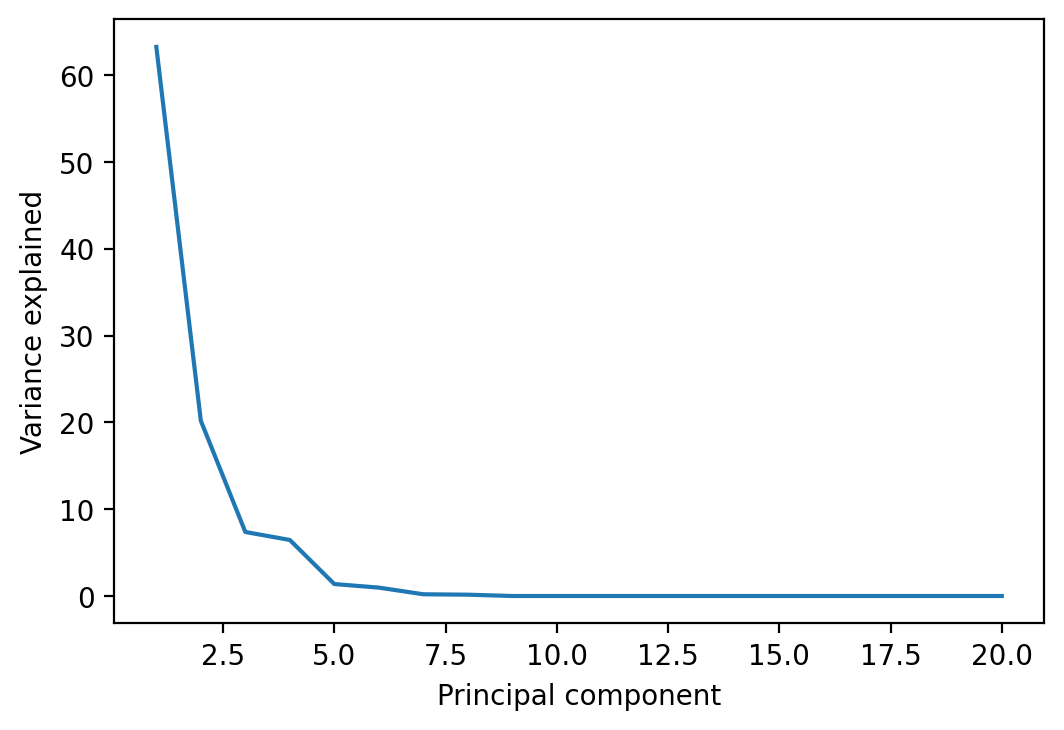

In [23]:
# Solution:
# Dead C. elegans
tangent_vectors_dead=np.zeros(complex_spline_preshapes_dead.shape, dtype=complex)
for i in range(len(complex_spline_preshapes_dead)):
    tangent_vectors_dead[i]=shape_space.log(mean_shape_Frechet_dead, complex_spline_preshapes_dead[i])

tangent_plane_pca_dead = B3_PCA(M, closed_curve, mean_shape_Frechet_dead)
tangent_plane_pca_dead.fit(tangent_vectors_dead)
    
plt.plot(np.linspace(1,len(tangent_plane_pca_dead.diag),len(tangent_plane_pca_dead.diag)),100*tangent_plane_pca_dead.diag/np.sum(tangent_plane_pca_dead.diag))
plt.xlabel("Principal component")
plt.ylabel("Variance explained")
plt.show()

# Live C. elegans
tangent_vectors_live=np.zeros(complex_spline_preshapes_live.shape, dtype=complex)
for i in range(len(complex_spline_preshapes_live)):
    tangent_vectors_live[i]=shape_space.log(mean_shape_Frechet_live, complex_spline_preshapes_live[i])

tangent_plane_pca_live = B3_PCA(M, closed_curve, mean_shape_Frechet_live)
tangent_plane_pca_live.fit(tangent_vectors_live)
    
plt.plot(np.linspace(1,len(tangent_plane_pca_live.diag),len(tangent_plane_pca_live.diag)),100*tangent_plane_pca_live.diag/np.sum(tangent_plane_pca_live.diag))
plt.xlabel("Principal component")
plt.ylabel("Variance explained")
plt.show()

**3.5** For each class, retreive the two first modes of shape variation and visualize them around the mean by adapting the code from 2.2. How do they differ from what you got in 2.2? And from what you got in 2A - 4.5?

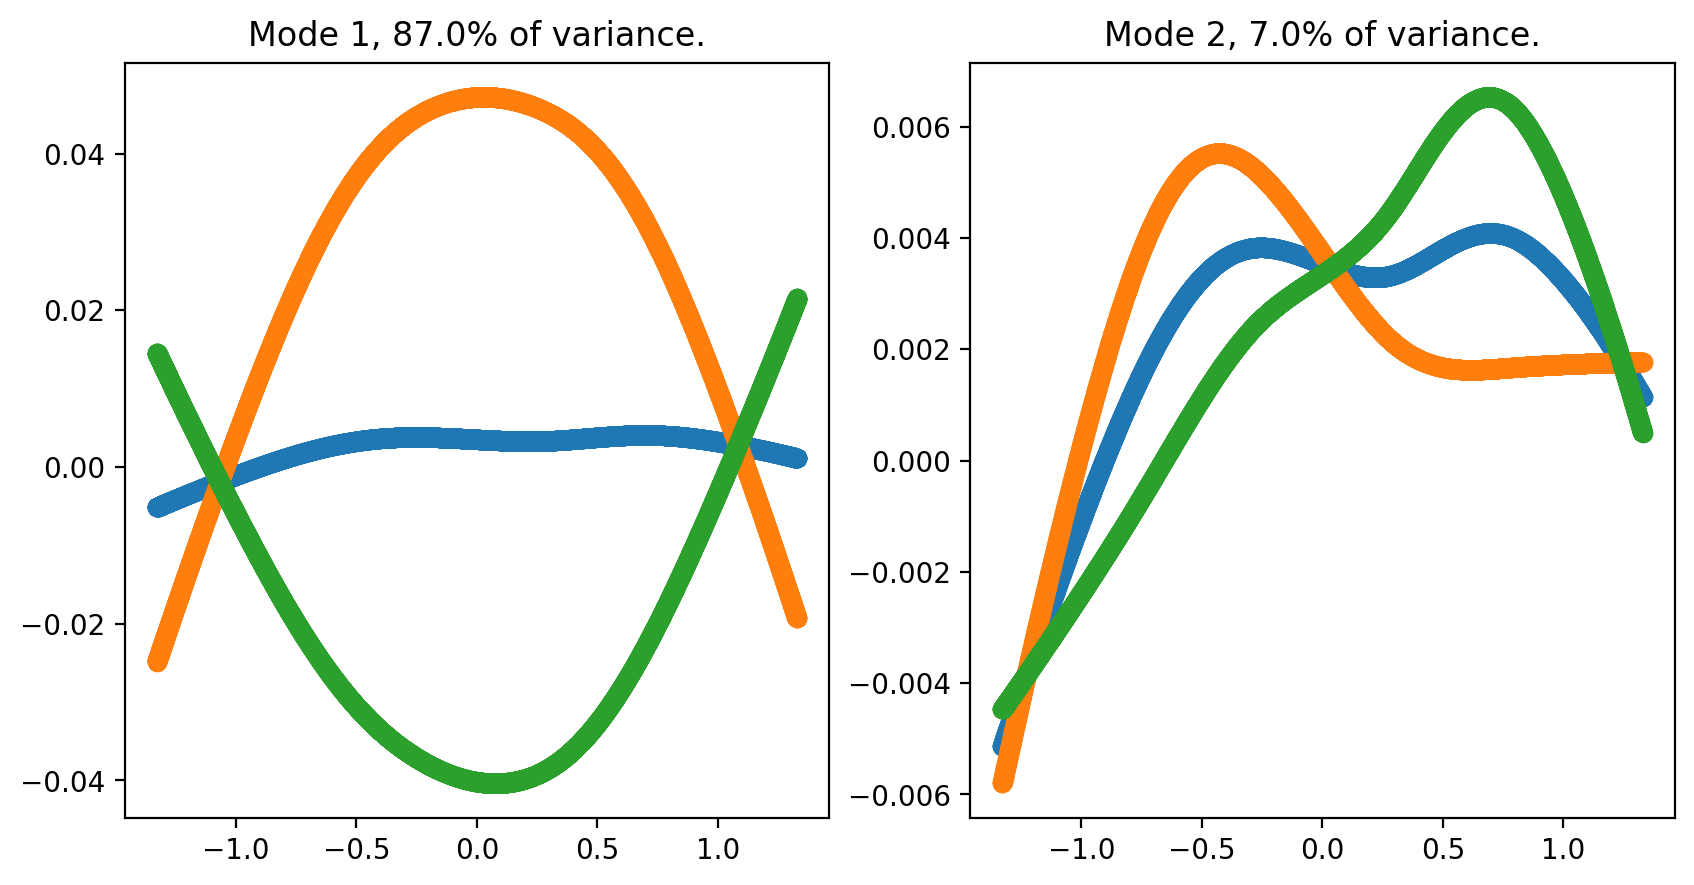

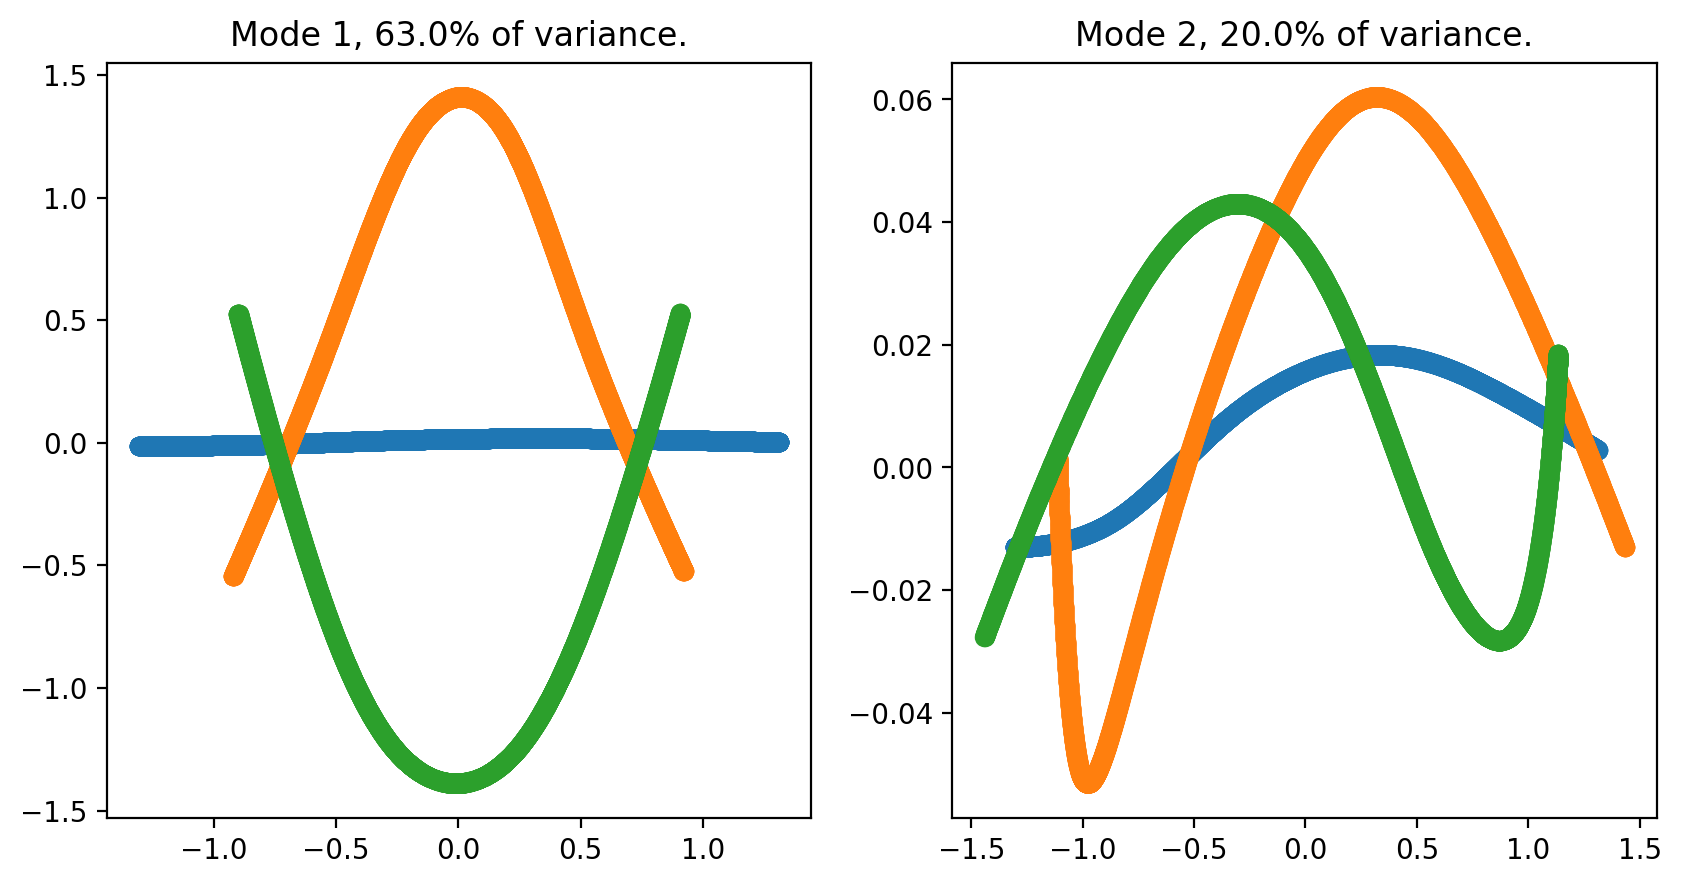

In [24]:
# Solution:
K=2

# Dead C. elegans
pcWeights_dead=np.zeros((K,2*tangent_plane_pca_dead.M))
for i in range(K):
    pcWeights_dead[i]=tangent_plane_pca_dead.project(tangent_vectors_dead[i])

modes_shape_dead=np.zeros((K,2,tangent_plane_pca_dead.M),dtype=np.complex)
for i in range(K):
    mode=np.std(pcWeights_dead[:,i])*np.sqrt(tangent_plane_pca_dead.diag[i])*tangent_plane_pca_dead.complexPC[:,i]
    modes_shape_dead[i][0]=shape_space.exponentialMap(mean_shape_Frechet_dead, mode)
    modes_shape_dead[i][1]=shape_space.exponentialMap(mean_shape_Frechet_dead, -mode)
    
fig, ax = plt.subplots(1, K, figsize=(5*K,5))
for i in range(K):
    ax[i].scatter(mean_shape_Frechet_dead_points[:,0],mean_shape_Frechet_dead_points[:,1])
    
    modes_shape_dead_0_points=draw_spline_model(modes_shape_dead[i][0])
    ax[i].scatter(modes_shape_dead_0_points[:,0],modes_shape_dead_0_points[:,1])
    
    modes_shape_dead_1_points=draw_spline_model(modes_shape_dead[i][1])
    ax[i].scatter(modes_shape_dead_1_points[:,0],modes_shape_dead_1_points[:,1])
    
    percent_variance=np.round(100*tangent_plane_pca_dead.diag[i]/np.sum(tangent_plane_pca_dead.diag))
    ax[i].set_title("Mode "+str(i+1)+", "+str(percent_variance)+"% of variance.")
    
# Live C. elegans   
pcWeights_live=np.zeros((K,2*tangent_plane_pca_live.M))
for i in range(K):
    pcWeights_live[i]=tangent_plane_pca_live.project(tangent_vectors_live[i])

modes_shape_live=np.zeros((K,2,tangent_plane_pca_live.M),dtype=np.complex)
for i in range(K):
    mode=np.std(pcWeights_live[:,i])*np.sqrt(tangent_plane_pca_live.diag[i])*tangent_plane_pca_live.complexPC[:,i]
    modes_shape_live[i][0]=shape_space.exponentialMap(mean_shape_Frechet_live, mode)
    modes_shape_live[i][1]=shape_space.exponentialMap(mean_shape_Frechet_live, -mode)
    
fig, ax = plt.subplots(1, K, figsize=(5*K,5))
for i in range(K):
    ax[i].scatter(mean_shape_Frechet_live_points[:,0],mean_shape_Frechet_live_points[:,1])
    
    modes_shape_live_0_points=draw_spline_model(modes_shape_live[i][0])
    ax[i].scatter(modes_shape_live_0_points[:,0],modes_shape_live_0_points[:,1])
    
    modes_shape_live_1_points=draw_spline_model(modes_shape_live[i][1])
    ax[i].scatter(modes_shape_live_1_points[:,0],modes_shape_live_1_points[:,1])

    percent_variance=np.round(100*tangent_plane_pca_live.diag[i]/np.sum(tangent_plane_pca_live.diag))
    ax[i].set_title("Mode "+str(i+1)+", "+str(percent_variance)+"% of variance.")

### 4. Statistical shape modelling with spline curves

**4.1** The following lines generate synthetic live C. elegans shapes relying on a simple statistical model (multivariate Gaussian) built from the covariance matrix of the dataset. How does it compare to the model considered in 2A - 5.1?

In [25]:
import scipy.linalg
import scipy.stats

In [26]:
count=3
num_synthetic_data=5

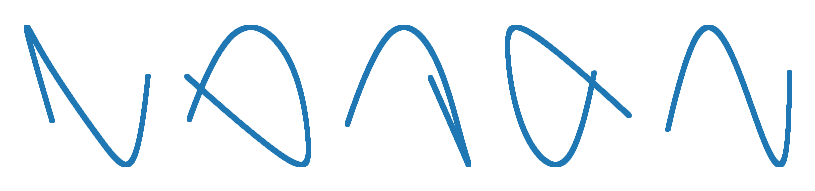

In [27]:
# Live C. elegans
synthetic_data_live=np.zeros((num_synthetic_data,tangent_plane_pca_live.M),dtype=np.complex)
for i in range(num_synthetic_data):
    rand=[]
    for k in range(len(tangent_plane_pca_live.diag)):
        var=tangent_plane_pca_live.diag[k]
        if var<1e-6:
            sigma=0.0
        else:
            sigma=np.sqrt(var)
        rand.append(scipy.stats.norm.rvs(loc=0, scale=sigma, size=1))
    rand=np.array(rand)

    v=np.zeros((tangent_plane_pca_live.M), dtype=complex)
    for k in range(count):
        zz = rand.T @ scipy.linalg.sqrtm(tangent_plane_pca_live.Psi)
        z = zz @ tangent_plane_pca_live.pcPhi[:,k]
        v+=(z*tangent_plane_pca_live.complexPC[:,k])
    
    synthetic_data_live[i]=shape_space.exponentialMap(mean_shape_Frechet_live, v)
    
fig, ax = plt.subplots(1, num_synthetic_data, figsize=(num_synthetic_data,1))
for i in range(num_synthetic_data):
    synthetic_data_live_points=draw_spline_model(synthetic_data_live[i])
    ax[i].scatter(synthetic_data_live_points[:,0],synthetic_data_live_points[:,1],s=.5)
    ax[i].axis("off")